In [118]:
#import packages
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt
import cv2

In [14]:
#load data
f=gzip.open('mnist.pkl.gz','rb')
u=pickle._Unpickler(f)
u.encoding='latin1'
training_data,validation_data,test_data=u.load()

In [55]:
#one hot encoder function
def one_hot_encoder(x):
    one_hot=np.zeros((len(x),10))
    rows=np.arange(x.size)
    one_hot[rows,x]=1
    return one_hot.T

In [56]:
#get training data
x_training_data=np.array(training_data[0]).T
y_training_data=one_hot_encoder(np.array(training_data[1]))

In [57]:
#get test data
x_test_data=np.array(test_data[0]).T
y_test_data=one_hot_encoder(np.array(test_data[1]))

In [58]:
#get devlopment data
x_dev_data=np.array(validation_data[0]).T
y_dev_data=one_hot_encoder(np.array(validation_data[1]))

In [48]:
#functions and derivative
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z),axis=0,keepdims=True)

def relu(z):
    return np.where(z>0,z,0.001*z)

def relu_(z):
    return np.where(z>0,1,0.001)

In [49]:
#cost function
def cost(y,yhat,m):
    return -1*np.sum(y*np.log(yhat))/m

In [23]:
#initialise epoch
def epoch(training_size,epoch_size,parameter,x1,y1):
    if training_size%epoch_size==0:
        size=training_size/epoch_size
        parameter["num_epoch"]=size
        for i in range(1,size+1):
            parameter["x"+str(i)]=x1[:,(i-1)*epoch_size:i*epoch_size]
            parameter["y"+str(i)]=y1[:,(i-1)*epoch_size:i*epoch_size]
        return parameter
    size=training_size//epoch_size
    parameter["num_epoch"]=size+1
    for i in range(1,size+1):
        parameter["x"+str(i)]=x1[:,(i-1)*epoch_size:i*epoch_size]
        parameter["y"+str(i)]=y1[:,(i-1)*epoch_size:i*epoch_size]
    parameter["x"+str(size+1)]=x1[:,size*epoch_size:-1]
    parameter["y"+str(size+1)]=y1[:,size*epoch_size:-1]
    return parameter

In [47]:
#initialise layer
def initialise_layer(x):
    layer=[x.shape[0],64,128,64,64,10]
    return layer

In [33]:
#initialise weights and bias
def initialise_wb(layer,parameter,L):
    for l in range(1,L+1):
        parameter["w"+str(l)]=np.random.randn(layer[l],layer[l-1])*((2/layer[l-1])**0.5)
        parameter["b"+str(l)]=np.zeros((layer[l],1))
    return parameter

In [42]:
#forward propagation
def forward_propagation(parameter,L):
    for l in range(1,L):
        parameter["a"+str(l)]=relu(np.dot(parameter["w"+str(l)],parameter["a"+str(l-1)])+parameter["b"+str(l)])
    parameter["a"+str(L)]=softmax(np.dot(parameter["w"+str(L)],parameter["a"+str(L-1)])+parameter["b"+str(L)])
    return parameter

In [35]:
#back propagation
def back_propagation(parameter,L,y,m):
    parameter["dz"+str(L)]=parameter["a"+str(L)]-y
    parameter["dw"+str(L)]=np.dot(parameter["dz"+str(L)],parameter["a"+str(L-1)].T)/m
    parameter["db"+str(L)]=np.sum(parameter["dz"+str(L)],axis=1,keepdims=True)/m
    for l in reversed(range(1,L)):
        parameter["dz"+str(l)]=np.dot(parameter["w"+str(l+1)].T,parameter["dz"+str(l+1)])*relu_(parameter["a"+str(l)])
        parameter["dw"+str(l)]=np.dot(parameter["dz"+str(l)],parameter["a"+str(l-1)].T)/m
        parameter["db"+str(l)]=np.sum(parameter["dz"+str(l)],axis=1,keepdims=True)/m
    return parameter

In [36]:
#gradiant descent withought adam
def gradiant_discent(parameter,alpha,L):
    for l in range(1,L+1):
        parameter["w"+str(l)]=parameter["w"+str(l)]-alpha*parameter["dw"+str(l)]
        parameter["b"+str(l)]=parameter["b"+str(l)]-alpha*parameter["db"+str(l)]
    return parameter

In [68]:
#training data
def start_training(parameter,L,alpha):
    for i in range(1,parameter["num_epoch"]+1):
        parameter["a0"]=parameter["x"+str(i)]
        parameter=forward_propagation(parameter,L)
        parameter=back_propagation(parameter,L,parameter["y"+str(i)],parameter["y"+str(i)].shape[1])
        parameter=gradiant_discent(parameter,alpha,L)
    return parameter

In [83]:
#test on dev data
def start_test(parameter,L,m,y):
    parameter=forward_propagation(parameter,L)
    acc=0
    for i in range(y.shape[1]):
        max_=0
        for j in range(10):
            max_=max_ if parameter["a"+str(L)][max_][i]>parameter["a"+str(L)][j][i] else j
        if y[max_][i]==1:
            acc+=1
    print("Accuracy on dev set is",acc*100/y.shape[1],"%")

In [169]:
#train
def train():
    x1=x_training_data
    y1=y_training_data
    layer=initialise_layer(x1)
    L=len(layer)-1
    parameter={}
    parameter=initialise_wb(layer,parameter,L)
    epoch_size=256
    parameter=epoch(x1.shape[1],epoch_size,parameter,x1,y1)
    num_iteration=150
    alpha=0.005
    x=x_dev_data
    y=y_dev_data
    for i in range(1,num_iteration+1):
        parameter=start_training(parameter,L,alpha)
        if i%5==0:
            parameter["a0"]=x1
            parameter=forward_propagation(parameter,L)
            print("At",i,"th iteration cost ===>>>",cost(y1,parameter["a"+str(L)],y1.shape[1]))
            acc=0
            for k in range(y1.shape[1]):
                max_=0
                for j in range(10):
                    max_=max_ if parameter["a"+str(L)][max_][k]>parameter["a"+str(L)][j][k] else j
                if y1[max_][k]==1:
                    acc+=1
            print("Accuracy on training set is",acc*100/y1.shape[1],"%")
            m=x.shape[1]
            parameter["a0"]=x
            start_test(parameter,L,m,y)
    return parameter,L

In [170]:
#application
parameter,L=train()

At 5 th iteration cost ===>>> 0.7132369037782093
Accuracy on training set is 80.856 %
Accuracy on dev set is 82.11 %
At 10 th iteration cost ===>>> 0.40401068569294396
Accuracy on training set is 88.746 %
Accuracy on dev set is 89.79 %
At 15 th iteration cost ===>>> 0.3190465603606973
Accuracy on training set is 90.902 %
Accuracy on dev set is 91.65 %
At 20 th iteration cost ===>>> 0.2735814973649217
Accuracy on training set is 92.088 %
Accuracy on dev set is 92.95 %
At 25 th iteration cost ===>>> 0.24232972595327615
Accuracy on training set is 93.016 %
Accuracy on dev set is 93.68 %
At 30 th iteration cost ===>>> 0.21832532762780907
Accuracy on training set is 93.708 %
Accuracy on dev set is 94.23 %
At 35 th iteration cost ===>>> 0.19893508537138782
Accuracy on training set is 94.234 %
Accuracy on dev set is 94.73 %
At 40 th iteration cost ===>>> 0.18289630642311192
Accuracy on training set is 94.714 %
Accuracy on dev set is 94.95 %
At 45 th iteration cost ===>>> 0.16938048157369917
A

In [172]:
#test on test data
parameter["a0"]=x_test_data
y=y_test_data
parameter=forward_propagation(parameter,L)
acc=0
for i in range(y.shape[1]):
    max_=0
    for j in range(10):
        max_=max_ if parameter["a"+str(L)][max_][i]>parameter["a"+str(L)][j][i] else j
    if y[max_][i]==1:
        acc+=1
print("Accuracy on test set is",acc*100/y.shape[1],"%")

Accuracy on test set is 96.55 %


In [173]:
#COLLECTING DATA
weight=[]
bias=[]
for l in range(L):
    weight.append(parameter["w"+str(l+1)])
    bias.append(parameter["b"+str(l+1)])
pickle.dump(weight,open("weight.p","wb"))
pickle.dump(bias,open("bias.p","wb"))
pickle.dump(L,open("length.p","wb"))

Predicted Number is  4


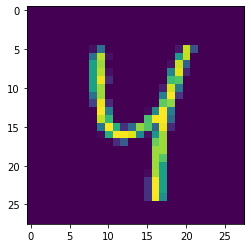

In [168]:
#testing data
x=x_test_data.T[2022].reshape(784,1)
plt.imshow(x.reshape(28,28))
parameter["a0"]=x
parameter=forward_propagation(parameter,L)
max_=0
for i in range(10):
    max_=max_ if parameter["a"+str(L)][max_][0]>parameter["a"+str(L)][i][0] else i
print("Predicted Number is ",max_)

Predicted Number with top 3 priority is  5 3 9


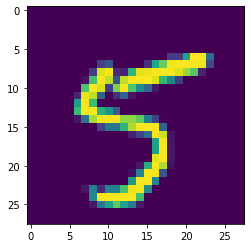

In [166]:
#testing data with top 3 predictions
x=x_test_data.T[2021].reshape(784,1)
plt.imshow(x.reshape(28,28))
parameter["a0"]=x
parameter=forward_propagation(parameter,L)
arr=np.array(parameter["a"+str(L)])
sort_array=[]
for i in range(10):
    sort_array.append((arr[i],i))
for i in range(10):
    for j in range(i,10):
        if sort_array[i][0]<sort_array[j][0]:
            sort_array[i],sort_array[j]=sort_array[j],sort_array[i]
print("Predicted Number with top 3 priority is ",sort_array[0][1],sort_array[1][1],sort_array[2][1])

Predicted Number with top 3 priority is  2 4 6


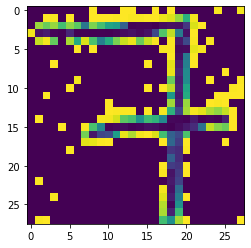

In [165]:
#testing own image with top 3 priority
img=cv2.imread("test.jpg",0)
img=cv2.resize(img,(28,28))/255
img=np.where(img==1,0,img)
plt.imshow(img)
parameter["a0"]=img.reshape(784,1)
parameter=forward_propagation(parameter,L)
arr=np.array(parameter["a"+str(L)])
sort_array=[]
for i in range(10):
    sort_array.append((arr[i],i))
for i in range(10):
    for j in range(i,10):
        if sort_array[i][0]<sort_array[j][0]:
            sort_array[i],sort_array[j]=sort_array[j],sort_array[i]
print("Predicted Number with top 3 priority is ",sort_array[0][1],sort_array[1][1],sort_array[2][1])